## Import module

In [1]:
#basic module
import pandas as pd # data processing
import numpy as np # linear algebra
import seaborn as sns
from matplotlib import pyplot as plt
import os
import time
import copy

#data preprocessing
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, Binarizer
from sklearn.model_selection import train_test_split, GridSearchCV,cross_validate


# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#Importing Library

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report, roc_auc_score, roc_curve

start = time.time()

/home/yongk/anaconda3/envs/BK/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set GPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print("running on the CPU")

running on the GPU


In [3]:
os.environ['CUDA_LAUNCH_BLOCKING']= "-1"

#### reference
- Heart Disease Prediction : https://www.kaggle.com/code/omarmohamedyehia/heart-disease-prediction

## Data Check

In [13]:
train = pd.read_csv("train_SMOTE_not.csv",parse_dates=True, dayfirst=False)
val = pd.read_csv("val.csv",parse_dates=True, dayfirst=False)
test = pd.read_csv("test.csv",parse_dates=True, dayfirst=False)

In [14]:
train = train.sample(frac=1).reset_index(drop=True)  # shuffling하고 index reset

In [15]:
train = train.iloc[:-1,:]
val = val.iloc[:-1,:]
test = test.iloc[:-1,:]

In [16]:
# data split
X_train= train.iloc[:,1:].values
y_train= train.iloc[:,:1].values
X_val= val.iloc[:,1:].values
y_val= val.iloc[:,:1].values
X_test= test.iloc[:,1:].values
y_test= test.iloc[:,:1].values

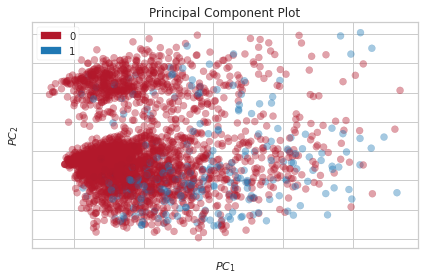

In [24]:
from yellowbrick.features import PCA as yellowPCA
def pca_visualisation_2d(df_temp : pd.DataFrame, target_col : str) -> None:
    """
    Visualize 2d
    
    Parameters
    ----------
    df_temp : pd.DataFrame
        The dataframe to use features from for embedding
    target_col : str
        The target variable to be dropped from dataframe
    """
    if len(df_temp) > 3000:
        df_temp = df_temp.copy().sample(n=2999, random_state=1)
    y = df_temp[target_col]
    X = df_temp.drop(columns=[target_col])
    visualizer = yellowPCA(scale=True, projection=2, alpha=0.4, colors = ['#b2182b','#1f78b4'])
    visualizer.fit_transform(X, y)
    visualizer.show()
    plt.show()

pca_visualisation_2d(train, "HeartDisease")

In [9]:
!pip install yellowbrick

     |████████████████████████████████| 274 kB 9.4 MB/s eta 0:00:01


### DNN

In [10]:
USE_CUDA = torch.cuda.is_available()
torch.cuda.is_available()

True

In [11]:
device = torch.device("cuda" if USE_CUDA else "cpu")
print(device)

cuda


<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

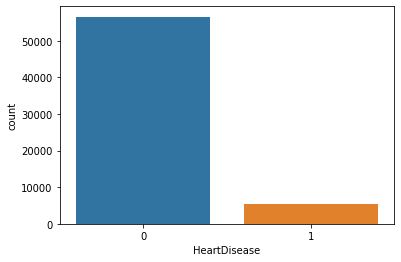

In [20]:
sns.countplot(x="HeartDisease", data=test)

In [21]:
No_Value_test = test.HeartDisease.value_counts()[0]
Yes_Value_test = test.HeartDisease.value_counts()[1]
print("The number of Yes Value has {}%".format(((Yes_Value_test/len(test))*100).round(2)))

The number of Yes Value has 8.6%


In [20]:
# Set Hyper parameters and other variables to train the model.
epochs = 20
momentum = 0.5
log_interval = 200

In [12]:
from torch.utils.data import Dataset

## Dataset에서 데이터 읽고, 전처리(데이터 나누기, Scaling)
class CustomDataset(Dataset): # Dataset 클래스 상속
    
    def __init__(self, X_data, y_data, device):
        self.device = device
        self.X_data = torch.tensor(X_data, device = self.device, dtype = torch.float32)
        self.y_data = torch.tensor(y_data, device = self.device, dtype = torch.float32)
        
        super().__init__()
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


In [13]:
train_loader = DataLoader(dataset=CustomDataset(X_train, y_train, device), batch_size=2048, shuffle=True) # 학습셋만 test하는 것 필수
val_loader = DataLoader(dataset=CustomDataset(X_val, y_val, device), batch_size=2048)
test_loader = DataLoader(dataset=CustomDataset(X_test, y_test, device), batch_size=2048)

In [14]:
# train, valid, test 데이터 각각의 DataLoader 객체 생성 완료
print("Train %d / Valid %d / Test %d samples." % (
    len(train_loader.dataset),
    len(val_loader.dataset),
    len(test_loader.dataset),
))

Train 387055 / Valid 30939 / Test 61879 samples.


In [15]:
y_test

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [16]:
# 모델 정의
class Net(nn.Module): # 신경망 모듈 상속받는 파이썬 클래스 정의
    def __init__(self, input_size, hidden_size): # 객체 생성 시 자동 호출 되는 init 함수
        super(Net, self).__init__() # Net 클래스가 nn.Module의 속성을 갖고 초기화
        self.input_size = input_size # 입력 데이터의 차원
        self.hidden_size = hidden_size # linear layer 내 은닉 유닛 개수
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU() # activation function ReLU 선언
        self.fc2 = nn.Linear(self.hidden_size, 64)
        self.fc3 = nn.Linear(64, 1)
        self.fc4 = nn.Linear(8, 1)
        self.batchnorm_init = nn.BatchNorm1d(16)
        self.batchnorm = nn.BatchNorm1d(8)
        self.dropout = nn.Dropout(0.5)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        linear1 = self.fc1(x)
#        batch1 = self.batchnorm_init(linear1)
        relu1 = self.relu(linear1)
#        drop1 = self.dropout(relu1)
        linear2 = self.fc2(relu1)
#        batch2 = self.batchnorm(linear2)
        relu2 = self.relu(linear2)
#        drop2 = self.dropout(relu2)
        linear3 = self.fc3(relu2)
#        batch3 = self.batchnorm(linear3)
        relu3 = self.relu(linear3)
#        drop3 = self.dropout(relu3)
#        linear4 = self.fc4(drop3)
        
        output = relu3
        
        return output

In [17]:
print("init model done")
net = Net(input_size = 34, hidden_size = 64).to(device)
print(net)

init model done
Net(
  (fc1): Linear(in_features=34, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
  (batchnorm_init): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (sigmoid): Sigmoid()
)


In [21]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[int(epochs * 0.5), int(epochs * 0.75)], gamma=0.1, last_epoch=-1)

In [19]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [22]:
%%time

min_valid_loss = np.inf
for e in range(epochs + 1):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    epoch_precision = 0
    epoch_recall = 0
    
    net.train()     # Optional when not using Model Specific layer
    for i, (X, y_batch) in enumerate(train_loader):
        X, y_batch = X.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        y_pred = net(X)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        #macro_f1 = F1(y_pred, y_batch)
        #precision = pre(y_pred, y_batch)
        #recall = rec(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        #epoch_f1 += macro_f1.item()
        #epoch_recall += recall.item()
        #epoch_precision += precision.item()
    
    valid_loss = 0.0
    val_epoch_acc = 0.0
    net.eval()     # Optional when not using Model Specific layer
    for i, (X, y_batch) in enumerate(val_loader):
        X, y_batch = X.to(device), y_batch.to(device)
        
        y_pred = net(X)
        loss = criterion(y_pred,y_batch)
        val_acc = binary_acc(y_pred, y_batch)
        
        valid_loss = loss.item() * X.size(0)
        val_epoch_acc += val_acc.item()

    print(f'Epoch {e+1} | Train Loss: {epoch_loss / len(train_loader)} | Train acc : {epoch_acc/ len(train_loader)} | Train f1 : {epoch_f1/ len(train_loader)} | Val Loss: {valid_loss / len(val_loader)} | Val acc : {val_epoch_acc/len(val_loader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(net.state_dict(), 'saved_model.pth')

Epoch 1 | Train Loss: 0.6785598990147707 | Train acc : 56.87830687830688 | Train f1 : 0.0 | Val Loss: 9.997287534177303 | Val acc : 38.4375
Validation Loss Decreased(inf--->159.956601) 	 Saving The Model
Epoch 2 | Train Loss: 0.6304285646115662 | Train acc : 70.53439153439153 | Train f1 : 0.0 | Val Loss: 10.672827165573835 | Val acc : 62.3125
Epoch 3 | Train Loss: 0.6075990231579573 | Train acc : 75.47619047619048 | Train f1 : 0.0 | Val Loss: 10.872987449169159 | Val acc : 68.375
Epoch 4 | Train Loss: 0.6033247895341701 | Train acc : 76.36507936507937 | Train f1 : 0.0 | Val Loss: 10.957980696111917 | Val acc : 69.8125
Epoch 5 | Train Loss: 0.6018435671215966 | Train acc : 76.63492063492063 | Train f1 : 0.0 | Val Loss: 10.919127199798822 | Val acc : 71.3125
Epoch 6 | Train Loss: 0.6010098205041633 | Train acc : 76.7989417989418 | Train f1 : 0.0 | Val Loss: 10.926247838884592 | Val acc : 71.625
Epoch 7 | Train Loss: 0.6004017449560619 | Train acc : 76.87830687830687 | Train f1 : 0.0 | Va

In [39]:
y_pred_list = []
net.eval()
thresholds = 0.3
binarizer = Binarizer(threshold = thresholds)

with torch.no_grad():
    for i, (X_batch, y) in enumerate(test_loader):
        X_batch = X_batch.to(device)
        y_test_pred = net(X_batch).cpu()
        y_pred_tag = torch.round(torch.sigmoid(y_test_pred))
#        binarizer = Binarizer(threshold = thresholds).fit(y_test_pred)
#        y_pred_tag = binarizer.transform(y_test_pred)
        y_pred_list.append(y_pred_tag)
        #y_pred_list.append(y_test_pred.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [40]:
y_pred_list = sum(y_pred_list, [])

In [41]:
y_pred_list

[1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0

In [42]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.97      0.73      0.83     56555
           1       0.22      0.79      0.34      5324

    accuracy                           0.74     61879
   macro avg       0.59      0.76      0.59     61879
weighted avg       0.91      0.74      0.79     61879



In [43]:
y_test_tensor = torch.tensor(y_test, dtype = torch.float32)
y_pred_list_tensor = torch.tensor(y_pred_list, dtype = torch.float32)

In [44]:
precision = precision_score(y_test_tensor, y_pred_list_tensor, average='macro', zero_division='warn')           
macro_f1 = f1_score(y_test_tensor, y_pred_list_tensor, zero_division='warn', average='macro')

In [45]:
accuracy = accuracy_score(y_test_tensor, y_pred_list_tensor)

In [46]:
recall = recall_score(y_test_tensor, y_pred_list_tensor, average='macro', zero_division='warn') #micro pos_label = 1

In [47]:
accuracy

0.7359039415633737

In [48]:
recall

0.7587927196127836

In [49]:
precision

0.5945763259724718

In [50]:
macro_f1

0.5869040809890618

In [51]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')

In [52]:
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 :{2:.4f}, F1 : {3:.4f}'.format(accuracy, precision, recall, f1))


In [53]:
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    pred_list = []
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        y_pred_tag = binarizer.transform(pred_proba_c1)
        pred_list.append(y_pred_tag)
        pred_list = [a.squeeze().tolist() for a in pred_list]
        pred_list = sum(pred_list, [])
        print(pred_list)
        print(y_test)
        exit()
        
        
        print('임곗값 : ', custom_threshold)
        get_clf_eval(y_test, custom_predict)

AUC:0.7587927196127836


<function matplotlib.pyplot.show(close=None, block=None)>

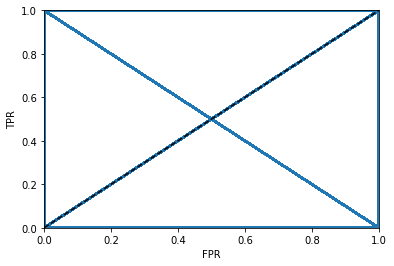

In [54]:
auc = roc_auc_score(y_test, y_pred_list)
fpr, tpr, thres = roc_curve(y_test, y_pred_list)
print('AUC:{}'.format(auc))
plot_roc_curve(y_test, y_pred_list)
plt.show

In [ ]:
for epoch in range (50):

    for i, (X, y_batch) in enumerate(trainLoder):

        trainn = Variable(images.view(-1,28*28))
        labels = Variable(labels.

        optimizer.zero_grad()

        output = model(trainn)

        loss = error(output,labels)

        loss.backward()

        optimizer.step()

        count+=1



        if (count%50==0):

            correct=0
            total = 0

            for image,label in testLoder:

                testt = Variable(image.view(-1,28*28))

                outputs = model(testt)

                predicted = torch.max(outputs.data,1)[1]

                total+=len(label)

                correct += (predicted == label).sum()

            accuracy = 100*correct/float(total)

            lossList.append(loss.data)
            iterationList.append(count)

        if (count%500==0):

            print("Epoch: {} Iteration: {} Loss: {} Accuracy: {}%".format(epoch,count,loss.data,accuracy))